# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
    # import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tables
from time import time

from sklearn.impute import SimpleImputer 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
#customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})

In [4]:
#azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})

# Data Exploration

In [5]:
%%time

file_customers= Path('customers.h5')
if file_customers.is_file():
    print ("load compressed customers file")
else:
    print ("compress data frame")
    customers.to_hdf(file_customers, key='customers', mode='w')

customers = pd.read_hdf(file_customers, 'customers')

file_azdias= Path('azdias.h5')
if file_azdias.is_file():
    print ("load compressed azdias file")
else:
    print ("compress azdias data frame")
    azdias.to_hdf(file_azdias, key='azdias', mode='w')

azdias = pd.read_hdf(file_azdias, 'azdias')
#print('load csv')
#azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'}) 
#azdias = pd.read_pickle(file_demographics)
#azdias.head(2)

load compressed customers file
load compressed azdias file
CPU times: user 18.2 s, sys: 46 s, total: 1min 4s
Wall time: 3min 21s


In [6]:
customers.describe() # delivers less useful info due to missing data

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [8]:
azdias.shape

(891221, 366)

In [9]:
%%time
feat_azdias = azdias.columns.values.tolist()
feat_info = pd.read_csv('data/feature_summary.csv', sep=',')
feat = feat_info.attribute.tolist()
feat_not_described = np.setdiff1d(feat_azdias,feat)
print (feat_not_described)
#customers[feat_not_described].median()
#print(customers.median().to_string())


['AKT_DAT_KL' 'ALTERSKATEGORIE_FEIN' 'ALTER_KIND1' 'ALTER_KIND2'
 'ALTER_KIND3' 'ALTER_KIND4' 'ANZ_KINDER' 'ANZ_STATISTISCHE_HAUSHALTE'
 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4'
 'CJT_TYP_5' 'CJT_TYP_6' 'D19_KONSUMTYP_MAX' 'D19_LETZTER_KAUF_BRANCHE'
 'D19_SOZIALES' 'D19_TELKO_ONLINE_QUOTE_12' 'D19_VERSI_ONLINE_QUOTE_12'
 'DSL_FLAG' 'EINGEFUEGT_AM' 'EINGEZOGENAM_HH_JAHR' 'EXTSEL992'
 'FIRMENDICHTE' 'GEMEINDETYP' 'HH_DELTA_FLAG' 'KBA13_ANTG1' 'KBA13_ANTG2'
 'KBA13_ANTG3' 'KBA13_ANTG4' 'KBA13_BAUMAX' 'KBA13_CCM_1401_2500'
 'KBA13_GBZ' 'KBA13_HHZ' 'KBA13_KMH_210' 'KOMBIALTER' 'KONSUMZELLE' 'LNR'
 'MOBI_RASTER' 'RT_KEIN_ANREIZ' 'RT_SCHNAEPPCHEN' 'RT_UEBERGROESSE'
 'STRUKTURTYP' 'UMFELD_ALT' 'UMFELD_JUNG' 'UNGLEICHENN_FLAG'
 'VERDICHTUNGSRAUM' 'VHA' 'VHN' 'VK_DHT4A' 'VK_DISTANZ' 'VK_ZG11']
CPU times: user 10.2 ms, sys: 14.1 ms, total: 24.3 ms
Wall time: 271 ms


In [10]:
#azdias.ALTER_KIND1.value_counts(dropna=False)
#azdias.TITEL_KZ.isnull().sum()
azdias.KK_KUNDENTYP.value_counts(dropna=False)

NaN    584612
3.0     65151
2.0     62564
5.0     48038
4.0     44512
6.0     44114
1.0     42230
Name: KK_KUNDENTYP, dtype: int64

# Initial Observations
- There are 360 features.
- The Data set takes long time to load. Calculating median too
- Intuitively, the most promising features should be year of birth\age, distance to next metropole (BALLRAUM), Age of Kids (ALTER_KINDx), 
- Not useful features for model: looking at median values lnr looks more of an index. 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP' only part of customer dataset.
- ALTER_KINDx has lot of unknown values, may be dropped or replaced with boolean 1-have kid 0-no or unknown difficult?
- EXTSEL992 not described and lot of unknown values
- KK_KUNDENTYP lot of unknown values hard to be imputed, but can be assumed to be median
- Can delete D19_x with 30 % missing value. Can be optimized: ALTERSKATEGORIE_FEIN
    

In [11]:
azdias_null = azdias.isnull().sum()
print (azdias_null.sort_values(ascending=False).to_string())
#azdias_null_percent = azdias_null / len(azdias) * 100
#(azdias_null_percent.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_LETZTER_KAUF_BRANCHE       257113
D19_LOTTO                      257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
KBA05_MOTOR                    133324
KBA05_MOD8                     133324
KBA05_MOD4                     133324
KBA05_MOD3                     133324
KBA05_MOD2                     133324
KBA05_SEG1                     133324
KBA05_MOD1                     133324
KBA05_MAXVORB                  133324
KBA05_MAXSEG                   133324
KBA05_MAXHERST                 133324
KBA05_MAXBJ 

In [12]:
feat_notpresent_customer = ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'] 
feat_notuseful = ['LNR', 'ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'KK_KUNDENTYP']
feat_notuseful_opt=['D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_BANKEN_ONLINE_QUOTE_12'
                    ,'D19_SOZIALES','D19_GESAMT_ONLINE_QUOTE_12','D19_KONSUMTYP','D19_TELKO_ONLINE_QUOTE_12',
                    'D19_VERSAND_ONLINE_QUOTE_12']
customers = customers.drop(columns=feat_notpresent_customer+feat_notuseful)
azdias = azdias.drop(columns=feat_notuseful)


In [13]:
print ('customers',customers.shape)
print ('azdias',azdias.shape)

customers (191652, 359)
azdias (891221, 359)


In [14]:
azdias[azdias.isnull().sum(axis=1)>0].isnull().sum(axis=1).sort_values(ascending=False)

537799    253
350182    253
373501    253
826869    253
55664     253
         ... 
108601      1
185710      1
498055      1
498060      1
226820      1
Length: 424497, dtype: int64

In [15]:
azdias = azdias[azdias.isnull().sum(axis=1) <= 50].reset_index(drop=True)
print ('azdias',azdias.shape)

azdias (751331, 359)


In [16]:
print (azdias.isnull().sum().sort_values(ascending=False).head())

ALTERSKATEGORIE_FEIN         174050
D19_SOZIALES                 171105
D19_VERSI_ONLINE_QUOTE_12    171105
D19_KONSUMTYP                171105
D19_LOTTO                    171105
dtype: int64


In [17]:
corr_azdias = azdias.corr().abs()

211


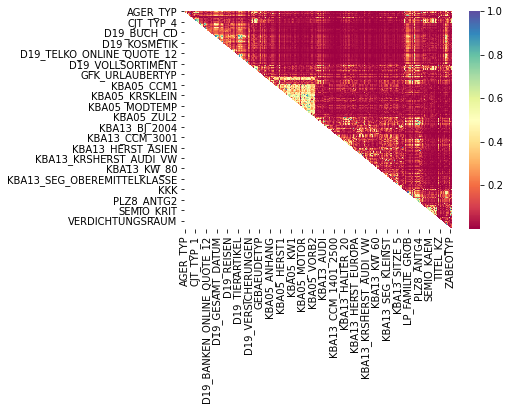

In [18]:
df_ut = corr_azdias.where(np.triu(np.ones(corr_azdias.shape),k=1).astype(np.bool))
hmap=sns.heatmap(df_ut,cmap="Spectral")
#df_ut.head()
#df_ut.AGER_TYP
drop_columns = [column for column in df_ut.columns if any(df_ut[column] > .5)]
print (len(drop_columns))

In [19]:
azdias_dropped_cols = azdias.drop(drop_columns, axis=1)
print('general population data with dropped cols', azdias_dropped_cols.shape)

general population data with dropped cols (751331, 148)


# Feature Processing

- Encoding: dummy variable
- handling categorical data type


In [20]:
feat_info.head()
#print (azdias_dropped_cols.dtypes.to_string())
object_cols = azdias_dropped_cols.select_dtypes(include='object').columns.values
azdias_dropped_cols[object_cols].nunique()
feat_notuseful_opt_categorical=['EINGEFUEGT_AM'] #2825 unique values
#customers = customers.drop(columns=feat_notuseful_opt_categorical)
azdias_dropped_cols = azdias_dropped_cols.drop(columns=feat_notuseful_opt_categorical)
#azdias_dropped_cols[object_cols].nunique()

In [21]:
azdias_encoded = pd.get_dummies(azdias_dropped_cols)
azdias_encoded.shape # Without handling object dtypes, explosion of variables in one-hot encoding (3292-211-148)

(751331, 256)

In [22]:
%%time
#imputer = SimpleImputer(missing_values='NaN',strategy='most_frequent',axis=0)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_encoded = imputer.fit_transform(azdias_encoded)
azdias_encoded = pd.DataFrame(azdias_encoded)


CPU times: user 20.9 s, sys: 19.1 s, total: 40 s
Wall time: 52.1 s


In [23]:
print('imputed azdias: ', azdias_encoded.shape)

imputed azdias:  (751331, 256)


In [25]:
%%time
# scale the data
scale = StandardScaler(copy=False)
azdias_encoded[azdias_encoded.columns] = scale.fit_transform(azdias_encoded)


CPU times: user 13.5 s, sys: 18.7 s, total: 32.2 s
Wall time: 50.1 s


In [26]:
azdias_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.572859,1.249446,-1.416979,0.159045,-0.128345,-0.296854,0.233463,-0.06062,-0.190387,0.851626,...,-0.134401,-0.119539,-0.055606,-0.567194,-0.180055,-0.274289,-0.20938,-0.051403,-0.51945,0.51945
1,-0.572859,1.249446,0.809514,0.095201,-0.128345,-0.296854,-0.626760,-0.06062,-0.190387,-0.975220,...,-0.134401,-0.119539,-0.055606,1.763064,-0.180055,-0.274289,-0.20938,-0.051403,-0.51945,0.51945
2,1.858228,-0.942562,0.285633,-0.479387,-0.128345,-0.296854,-1.486983,-0.06062,-1.195210,-0.061797,...,-0.134401,-0.119539,-0.055606,1.763064,-0.180055,-0.274289,-0.20938,-0.051403,-0.51945,0.51945
3,-0.572859,-0.942562,1.202425,-0.351701,-0.128345,-0.296854,1.953909,-0.06062,0.814436,-0.975220,...,-0.134401,-0.119539,-0.055606,-0.567194,-0.180055,-0.274289,-0.20938,-0.051403,-0.51945,0.51945
4,2.668591,-0.942562,-0.107277,-0.224014,-0.128345,-0.296854,-0.626760,-0.06062,-1.195210,0.851626,...,-0.134401,-0.119539,-0.055606,-0.567194,-0.180055,-0.274289,-0.20938,-0.051403,-0.51945,0.51945


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

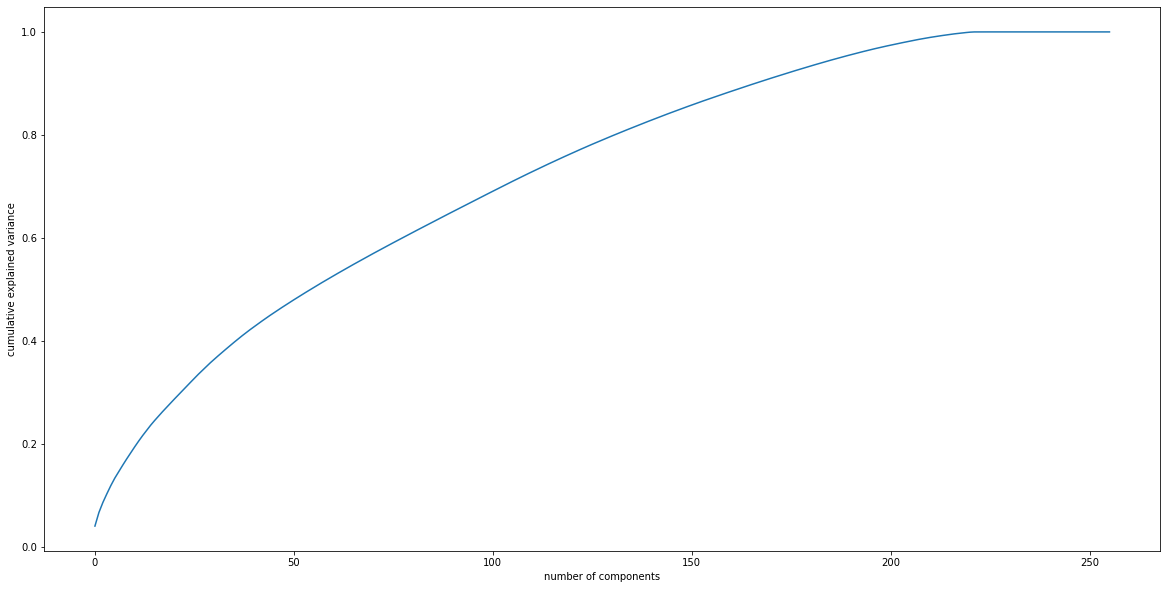

CPU times: user 1min 45s, sys: 46.9 s, total: 2min 32s
Wall time: 3min 44s


In [27]:
%%time
pca = PCA().fit(azdias_encoded)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


In [29]:
%%time
pca = PCA(n_components=230).fit(azdias_encoded)
azdias_encoded_pc230 = pca.transform(azdias_encoded)
reduced_data = pd.DataFrame(azdias_encoded_pc230)

CPU times: user 1min 55s, sys: 59.1 s, total: 2min 54s
Wall time: 5min 14s


In [31]:
%%time
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_data)
prediction_azdias = model_k.predict(reduced_data)

CPU times: user 9min 19s, sys: 43.8 s, total: 10min 3s
Wall time: 11min 8s


In [33]:
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

0      20577
1      49716
2      75027
3      59090
4      49673
5      74649
6      29743
7      20016
8      14043
9     192160
10     69138
11     97499
dtype: int64

In [45]:
ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
ratio = ratio.round(3)

weights = pd.DataFrame(pca.components_, columns = azdias_encoded.columns.values)
weights = weights.round(3)

ratio.head(10)
weights.head(10)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.029,-0.125,0.114,-0.102,-0.022,0.076,0.172,0.008,-0.120,0.054,...,0.008,0.006,0.012,-0.067,0.025,0.042,0.031,0.012,-0.080,0.080
1,0.013,-0.057,0.080,0.029,-0.020,0.044,0.085,-0.014,0.147,0.042,...,0.016,0.012,0.009,-0.048,0.023,0.026,0.028,0.001,0.227,-0.227
2,0.173,-0.070,-0.121,-0.051,0.005,-0.107,-0.040,0.013,-0.014,0.094,...,-0.024,-0.009,-0.006,0.090,-0.046,-0.011,0.017,0.011,0.106,-0.106
3,0.020,-0.012,0.011,0.132,0.085,-0.001,0.020,0.029,0.044,-0.147,...,0.004,0.003,0.001,-0.035,0.007,-0.012,0.010,0.009,-0.016,0.016
4,-0.146,0.085,0.023,-0.051,-0.048,0.069,0.002,-0.030,-0.143,0.132,...,-0.002,-0.009,0.004,-0.033,0.011,0.017,-0.028,-0.016,-0.089,0.089
5,-0.118,0.068,0.038,0.027,0.025,0.063,-0.011,0.007,0.060,0.022,...,0.006,0.002,0.001,-0.041,0.016,0.013,-0.006,-0.008,0.240,-0.240
6,-0.041,0.015,0.027,-0.047,-0.010,0.031,-0.011,-0.008,0.015,0.021,...,0.005,0.002,0.004,-0.025,0.016,0.009,0.001,-0.003,0.008,-0.008
7,-0.056,0.033,0.016,-0.045,-0.041,0.018,0.006,-0.007,0.004,-0.011,...,0.003,0.001,-0.002,-0.018,0.003,0.003,-0.009,-0.004,-0.021,0.021
8,-0.035,0.013,0.012,-0.071,-0.036,0.001,-0.023,-0.010,0.008,-0.006,...,-0.005,-0.004,0.001,-0.012,0.002,-0.002,0.005,-0.001,0.027,-0.027
9,0.004,-0.008,-0.003,-0.004,0.002,-0.003,-0.006,0.002,0.012,-0.008,...,0.001,0.001,-0.001,-0.007,-0.000,0.003,0.002,0.002,0.001,-0.001


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [7]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [8]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
